# Image Classification Notebook
#### Author: Tyler Newton  
  
### Part 1: Implement a Convolutional Neural Network for the [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10) dataset.  
#### Goals:
- Implement different network architectures (e.g. simple CNN's, ResNets, etc.) and report the results.
- Experiment with different optimizers and report the results.  
- Experiment with various other model parameters like learning rate and regularization.  

Reference to get started: [PyTorch CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)

GPUs: 0
Using cpu device
Files already downloaded and verified
Files already downloaded and verified


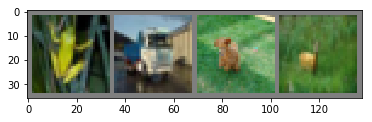

['frog', 'truck', 'dog', 'deer']
Length of training data: 50000
Length of testing data: 10000
Shape of CIFAR10 data: torch.Size([3, 32, 32])


In [1]:
# # # # # # # download/load, normalize, and preview CIFAR10 data using PyTorch # # # # # # #
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

# assigns GPU as device 
print(f'GPUs: {torch.cuda.device_count()}')
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(dev))

# create a transform with mean=(0.5, 0.5, 0.5), and std=(0.5, 0.5, 0.5) to transform images
# with range [0, 1] to tensors with range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# choose a batch size
batch_size = 4

# load CIFAR10 training batches using torchvision (into ./data directory) and normalize data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

# load normalized CIFAR10 test batches using torchvision
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

# explicitly define the classes present in CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# preview a batch of the training images with a helper function
def imshow(img):
    # first denormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of training data to preview
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

# print the batch labels
print([classes[labels[index]] for index in range(batch_size)])

# print some useful info
print(f"Length of training data: {len(trainset.data)}")
print(f"Length of testing data: {len(testset.data)}")
print(f"Shape of CIFAR10 data: {images[0].shape}")

Files already downloaded and verified
Files already downloaded and verified


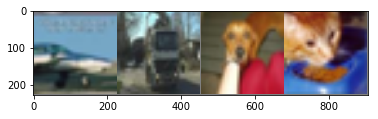

['plane', 'truck', 'dog', 'cat']
Length of training data transformed for ImageNet models: 50000
Length of testing data transformed for ImageNet models: 10000
Shape of CIFAR10 data transformed for ImageNet models: torch.Size([3, 224, 224])


In [2]:
# create another transform to adapt CIFAR-10 images to ImageNet models, i.e 224 x 224
# this transformation differs from the AlexNet transformation because I am not utilizing the pretrained model
# see this link for AlexNet transformation: https://pytorch.org/hub/pytorch_vision_alexnet/
imagenet_transform = transforms.Compose([transforms.Resize(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load CIFAR10 training batches resized for ImageNet models
imagenet_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=imagenet_transform)
imagenet_trainloader = torch.utils.data.DataLoader(imagenet_trainset, batch_size=batch_size, shuffle=True, num_workers=0)

# load CIFAR10 test batches resized for ImageNet models
imagenet_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=imagenet_transform)
imagenet_testloader = torch.utils.data.DataLoader(imagenet_testset, batch_size=batch_size, shuffle=False, num_workers=0)

# get a batch of training data to preview from ImageNet set
imagenet_dataiter = iter(imagenet_trainloader)
imagenet_images, imagenet_labels = imagenet_dataiter.next()
imshow(torchvision.utils.make_grid(imagenet_images))

# print the batch labels
print([classes[imagenet_labels[index]] for index in range(batch_size)])

# print some useful info
print(f"Length of training data transformed for ImageNet models: {len(imagenet_trainset.data)}")
print(f"Length of testing data transformed for ImageNet models: {len(imagenet_testset.data)}")
print(f"Shape of CIFAR10 data transformed for ImageNet models: {imagenet_images[0].shape}")

### First architecture: LeNet-5 adapted to 3-dimensional (RGB) data
[LeNet-5](https://en.wikipedia.org/wiki/LeNet) is one of the earliest simple convolutional neural networks. It was designed for a 1 x 32 x 32 greyscale input, so here it is adapted for a 3 x 32 x 32 RGB input to accomidate color images in the CIFAR-10 dataset.  
![LeNet-5 architecture](https://miro.medium.com/max/4308/1*1TI1aGBZ4dybR6__DI9dzA.png)

In [3]:
# # # # # # # build modified LeNet-5 CNN using torch.nn as base # # # # # # #
import torch.nn as nn
import torch.nn.functional as F

# initialize a dict to store different network architectures
networks = {}

# inherit neural network from PyTorch's torch.nn.Module
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__() # to inherit init of nn.Module
        # define the neural net layers:
        
        # convolutional layer with 3 input channels (RGB), 6 output channels, and a 5x5 convolution
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 2 x 2 max-pooling layer with stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        # convolutional layer with 6 input channels (RGB), 16 output channels, and a 5x5 convolution
        self.conv2 = nn.Conv2d(6, 16, 5)
        # linear layers: 120 -> 84 -> 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # define the forward pass through the network
    def forward(self, x):
        # 2 x 2 max-pooling layer with stride of 2 defined above
        x = self.pool(F.relu(self.conv1(x)))
        # another 2 x 2 max-pooling layer with stride of 2
        x = self.pool(F.relu(self.conv2(x)))
        # view tensor to reshape to 16 x 5 x 5
        x = x.view(-1, 16 * 5 * 5)
        # pass through linear layers fc1 -> fc2 -> fc3
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


# initialize the cnn and put it on a TPU
lenet5 = LeNet5().to(dev)

# print some useful info
print(f"Modified LeNet-5 parameters: {len(list(lenet5.parameters()))}")
print(f"Modified LeNet-5 architecture: \n{lenet5}")

# append network to networks dict to analyze later
networks[str(lenet5).split("(")[0]] = lenet5

Modified LeNet-5 parameters: 10
Modified LeNet-5 architecture: 
LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Second architecture: AlexNet adapted to CIFAR-10 data
[AlexNet](https://en.wikipedia.org/wiki/AlexNet) is a pivotal deep convolutional neural network. The [paper](https://kr.nvidia.com/content/tesla/pdf/machine-learning/imagenet-classification-with-deep-convolutional-nn.pdf) has been cited 80,436 times as of May 2, 2021, according to Google Scholar. It was designed for the 1000 classes of the [ImageNet Challenge](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge) with an input size of 3 x 224 x 224, so here it is adapted for 10 classes to accommodate the CIFAR-10 dataset. Additionally, the CIFAR-10 dataset is transformed to 3 x 224 x 224 (as above) to fit the AlexNet architecture. 
![AlexNet architecture](https://miro.medium.com/max/3688/1*eBDriuBwa5O8HPFUgerklA.png)

In [4]:
# AlexNet model adapted from https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html

# inherit neural network from PyTorch's torch.nn.Module
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        # view tensor to reshape to 256 x 6 x 6
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        
        return x

# initialize the cnn and put it on a TPU
alexnet = AlexNet().to(dev)

# print some useful info
print(f"Modified AlexNet parameters: {len(list(alexnet.parameters()))}")
print(f"Modified AlexNet architecture: \n{alexnet}")

# append network to networks dict to analyze later
networks[str(alexnet).split("(")[0]] = alexnet

Modified AlexNet parameters: 16
Modified AlexNet architecture: 
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
 

### Third architecture: ResNet 18
[ResNet18](https://arxiv.org/abs/1512.03385) is a residual neural network, meaning it utilizes skip connections to skip some layers during training. This concept has the benefit of avoiding vanishing gradients and accuracy saturation. It was designed for the 1000 classes of the [ImageNet Challenge](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge) with an input size of 3 x 224 x 224, so here it is adapted for 10 classes to accommodate the CIFAR-10 dataset. Additionally, the CIFAR-10 dataset is transformed to 3 x 224 x 224 (as above) to fit this architecture. 
![ResNet18 architecture](https://images1.programmersought.com/67/f9/f941fa481a9d8987b5022f1a8bade653.png)

In [5]:
# ResNet18 imported from torchvision

import torchvision.models as models
# import untrained model adapted for 10 classes and send it to the relevant device
resnet = models.resnet18(pretrained=False, num_classes=10).to(dev)

print(f"ResNet parameters: {len(list(resnet.parameters()))}")
print(f"ResNet architecture: \n{resnet}")

# append network to networks dict to analyze later
networks[str(resnet).split("(")[0]] = resnet

ResNet parameters: 62
ResNet architecture: 
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

### First optimizer: [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) with momentum
SGD with momentum is a stochastic approximation of gradient descent optimization from a subset of the data. "Momentum" refers to a method applied to SGD that accelerates gradient vectors in the desired direction. 

In [6]:
# # # # # # # utilize classification cross-entropy loss and SGD with momentum # # # # # # #
import torch.optim as optim
import copy

# initialize a dict to store different optimizers for each network
optimizers = {}

# initialize a dict to save all network/optimizer permutations for comparison
network_permutations = {}

# initialize an SGD optimizer for each network
for network_name in networks.keys():
    network = networks[network_name]
    
    # copy network to dict to later train and compare all network-optimizer permutations
    network_permutations[network_name] = {"SGD" : copy.deepcopy(network)}
    network = network_permutations[network_name]["SGD"]
    
    optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

    # add list containing optimizer to optimizers dict using network name as key
    optimizers[network_name] = [optimizer]

### Second optimizer: ADAM
ADAM, or adaptive moment estimation, considers running averages of the gradients and the second moments of the gradients to improve performance on sparse gradients and noisy problems.

In [7]:
# # # # # # # ADAM # # # # # # #

# initialize an ADAM optimizer for each network
for network_name in networks.keys():
    network = networks[network_name]
    
    # copy network to dict to later train and compare all network-optimizer permutations
    network_permutations[network_name]["Adam"] = copy.deepcopy(network)
    network = network_permutations[network_name]["Adam"]
    
    optimizer = optim.Adam(network.parameters(), lr=0.001)

    # add list containing optimizer to optimizers dict using network name as key
    optimizers[network_name].append(optimizer)

### Third optimizer: Adagrad
Adagrad is a SGD optimizer that adapts the learning rate to the parameters, which is sometimes beneficial for sparse data.

In [8]:
# # # # # # # Adagrad # # # # # # #

# initialize an Adagrad optimizer for each network
for network_name in networks.keys():
    network = networks[network_name]
    
    # copy network to dict to later train and compare all network-optimizer permutations
    network_permutations[network_name]["Adagrad"] = copy.deepcopy(network)
    network = network_permutations[network_name]["Adagrad"]
    
    optimizer = optim.Adagrad(network.parameters(), lr=0.001)

    # add list containing optimizer to optimizers dict using network name as key
    optimizers[network_name].append(optimizer)
    
print(optimizers)

{'LeNet5': [SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Adagrad (
Parameter Group 0
    eps: 1e-10
    initial_accumulator_value: 0
    lr: 0.001
    lr_decay: 0
    weight_decay: 0
)], 'AlexNet': [SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Adagrad (
Parameter Group 0
    eps: 1e-10
    initial_accumulator_value: 0
    lr: 0.001
    lr_decay: 0
    weight_decay: 0
)], 'ResNet': [SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0


### Train the different networks with the specified optimizers:

In [ ]:
# time it
start = time.time()

# loop through each network architecture, optimizer, and train all combinations to compare performance
epochs = 2

# define the loss criterion
criterion = nn.CrossEntropyLoss() #.to(dev)

# loop through all network architectures
for network_name in optimizers.keys(): 
    
    # loop through all optimizers
    for optimizer in optimizers[network_name]: 
        
        # get the relevant network for the current network/optimizer permutation
        optimizer_name = str(optimizer).split("(")[0].strip()
        network = network_permutations[network_name][optimizer_name]
        
        # loop over the training dataset the specified number of times (epochs)
        for epoch in range(epochs):
            
            # initialize loss to zero for each epoch
            running_loss = 0.0
            
            # loop over all training data batches
            
            # use 32 x 32 
            if network_name == "LeNet5":
                for i, data in enumerate(trainloader, 0):
                    # unpack tuple
                    inputs, labels = data
                    # put inputs and labels on GPU
                    inputs = inputs.to(dev)
                    labels = labels.to(dev)

                    # zero out parameter gradients
                    optimizer.zero_grad()

                    # forward pass, backward pass, and optimization
                    outputs = network(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    # print statistics every 2000 batches
                    running_loss += loss.item()
                    if i % 2000 == 1999:
                        print('Epoch: %d, Batch: %5d, Loss: %.3f' %
                              (epoch + 1, i + 1, running_loss / 2000))
                        running_loss = 0.0
            
            # use 224 x 224 
            else:
                for i, data in enumerate(imagenet_trainloader, 0):
                    # unpack tuple
                    inputs, labels = data
                    # put inputs and labels on GPU
                    inputs = inputs.to(dev)
                    labels = labels.to(dev)

                    # zero out parameter gradients
                    optimizer.zero_grad()

                    # forward pass, backward pass, and optimization
                    outputs = network(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    # print statistics every 2000 batches
                    running_loss += loss.item()
                    if i % 2000 == 1999:
                        print('Epoch: %d, Batch: %5d, Loss: %.3f' %
                              (epoch + 1, i + 1, running_loss / 2000))
                        running_loss = 0.0

        print(f'Finished training {network_name} : {str(optimizer).split("(")[0]}')
        
end = time.time()
hours = int((end - start) / 60 / 60)
minutes = int(((end - start) / 60) - (hours * 60))
seconds = int((end - start) - (minutes * 60) - (hours * 60 * 60))
print(f"Runtime: {hours} h {minutes} m {seconds} s")

### Check performance of the networks with the specified optimizers:

In [ ]:
# loop through all network architectures
for network_name in optimizers.keys(): 
    
    # loop through all optimizers
    for optimizer in optimizers[network_name]: 
        
        # get the relevant network for the current network/optimizer permutation
        optimizer_name = str(optimizer).split("(")[0].strip()
        network = network_permutations[network_name][optimizer_name]

        # keep track of total predictions and correct predictions
        correct = 0
        total = 0

        # don't calculate gradients for outputs while analyzing overall performance
        with torch.no_grad():

            # loop over all testing data batches
            
            # use 32 x 32 
            if network_name == "LeNet5":
                for data in testloader:
                    # unpack tuple
                    images, labels = data
                    # put inputs and labels on GPU
                    images = images.to(dev)
                    labels = labels.to(dev)

                    # calculate outputs by running images through the network
                    outputs = network(images)

                    # the class with the highest energy is the prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                  
            # use 224 x 224
            else:
                for data in imagenet_testloader:
                    # unpack tuple
                    images, labels = data
                    # put inputs and labels on GPU
                    images = images.to(dev)
                    labels = labels.to(dev)

                    # calculate outputs by running images through the network
                    outputs = network(images)

                    # the class with the highest energy is the prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

        print(f'Accuracy of {network_name} : {str(optimizer).split("(")[0].strip()} on test images: {(100 * correct / total)}%')

### Results: for lr = 0.001, weight_decay=0 (L2)  

**architecture : optimizer ::: start loss -> end loss**

LeNet5 : SGD      ::: Loss: 2.173 -> 1.304  
LeNet5 : Adam     ::: Loss: 1.844 -> 1.266  
LeNet5 : Adagrad  ::: Loss: 2.145 -> 1.798  
AlexNet : SGD     ::: Loss: 2.279 -> 1.009  
AlexNet : Adam    ::: Loss: 2.312 -> 2.303  
AlexNet : Adagrad ::: Loss: 1.898 -> 0.960  
ResNet : SGD      ::: Loss: 2.081 -> 0.928  
ResNet : Adam     ::: Loss: 2.177 -> 0.853  
ResNet : Adagrad  ::: Loss: 1.815 -> 1.041  
Runtime:  16 h  33 m  (CPU)  
Runtime:  1 h   12 m  (GPU)  
Accuracy of LeNet5 : SGD on test images: 53.11%  
Accuracy of LeNet5 : Adam on test images: 55.82%  
Accuracy of LeNet5 : Adagrad on test images: 35.62%  
Accuracy of AlexNet : SGD on test images: 65.63%  
Accuracy of AlexNet : Adam on test images: 10.0%  
Accuracy of AlexNet : Adagrad on test images: 66.87%  
Accuracy of ResNet : SGD on test images: 68.79%  
Accuracy of ResNet : Adam on test images: 69.95%  
Accuracy of ResNet : Adagrad on test images: 64.24%  

### Results: for lr = 0.10, weight_decay=0 (L2)
LeNet5 : SGD      ::: Loss: 2.362 -> 2.358  
LeNet5 : Adam     ::: Loss: 3.188 -> 2.341  
LeNet5 : Adagrad  ::: Loss: 2.565 -> 2.303  
AlexNet : SGD     ::: Loss: 2.361 -> 2.362  
AlexNet : Adam    ::: Loss: 8576643381.285 -> 20.033  
AlexNet : Adagrad ::: Loss: 17674910743.70 -> 2.309  
ResNet : SGD      ::: Loss: 2.385 -> 1.168  
ResNet : Adam     ::: Loss: 2.460 -> 2.342  
ResNet : Adagrad  ::: Loss: 2.192 -> 1.061  
Runtime:  1 h  11 m (GPU)  
Accuracy of LeNet5 : SGD on test images: 10.0%  
Accuracy of LeNet5 : Adam on test images: 10.0%  
Accuracy of LeNet5 : Adagrad on test images: 10.0%  
Accuracy of AlexNet : SGD on test images: 10.0%  
Accuracy of AlexNet : Adam on test images: 10.0%  
Accuracy of AlexNet : Adagrad on test images: 9.7%  
Accuracy of ResNet : SGD on test images: 63.09%  
Accuracy of ResNet : Adam on test images: 10.0%  
Accuracy of ResNet : Adagrad on test images: 62.48%  

### Results: for lr = 0.001, weight_decay=0.0001 (weighted L2)
LeNet5 : SGD      ::: Loss: 2.208 -> 1.281  
LeNet5 : Adam     ::: Loss: 1.897 -> 1.270  
LeNet5 : Adagrad  ::: Loss: 2.129 -> 1.798  
AlexNet : SGD     ::: Loss: 2.272 -> 1.032
AlexNet : Adam    ::: Loss: 2.307 -> 2.313  
AlexNet : Adagrad ::: Loss: 1.866 -> 1.027  
ResNet : SGD      ::: Loss: 2.096 -> 0.898  
ResNet : Adam     ::: Loss: 2.151 -> 0.970  
ResNet : Adagrad  ::: Loss: 1.806 -> 1.010  
Runtime:  1 h  17 m (GPU)  
Accuracy of LeNet5 : SGD on test images: 53.83%  
Accuracy of LeNet5 : Adam on test images: 53.99%  
Accuracy of LeNet5 : Adagrad on test images: 35.47%  
Accuracy of AlexNet : SGD on test images: 64.14%  
Accuracy of AlexNet : Adam on test images: 9.92%  
Accuracy of AlexNet : Adagrad on test images: 65.7%  
Accuracy of ResNet : SGD on test images: 68.5%  
Accuracy of ResNet : Adam on test images: 67.44%  
Accuracy of ResNet : Adagrad on test images: 64.76%  

### Part 2: Implement a linear classifier for the [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10) dataset.  
- Compare single linear layer vs. multiple linear layers
- Compare inclusion of bias term vs. no bias term

In [9]:
# # # # # # # build linear classifier with single layer using torch.nn as base # # # # # # #
start = time.time() # time it

# inherit neural network from PyTorch's torch.nn.Module
class LinearClassifier(nn.Module):
    def __init__(self,):
        super().__init__() # to inherit init of nn.Module
        # input is 32 * 32 * 3 for cifar-10 and output is 10 classes
        self.layer1 = nn.Linear(32*32*3, 10, bias=True)
        # map to outputs with softmax
        self.sm = nn.Softmax(dim=1)

    # define the forward pass through the network
    def forward(self, x):
        x = x.reshape(-1, 3072)
        x = self.layer1(x)
        x = self.sm(x)
        
        return x


# initialize the network
network = LinearClassifier()

# print some useful info
print(f"Linear classifier parameters: {len(list(network.parameters()))}")
print(f"Linear classifier architecture: \n{network}")

# set criterion, optimizer, and epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.001)
epochs = 10

# loop over epochs and train the model
for epoch in range(epochs):

    # initialize loss to zero for each epoch
    running_loss = 0.0

    # loop over all training data batches
    for i, data in enumerate(trainloader, 0):
        # unpack tuple
        inputs, labels = data

        # zero out parameter gradients
        optimizer.zero_grad()

        # forward pass, backward pass, and optimization
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics every 2000 batches
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('Epoch: %d, Batch: %5d, Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
# keep track of total predictions and correct predictions
correct = 0
total = 0

# don't calculate gradients for outputs while analyzing overall performance
with torch.no_grad():

    # loop over all testing data batches and get the accuracy
    for data in testloader:
        # unpack tuple
        images, labels = data

        # calculate outputs by running images through the network
        outputs = network(images)

        # the class with the highest energy is the prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test images: {(100 * correct / total)}%')

end = time.time()
hours = int((end - start) / 60 / 60)
minutes = int(((end - start) / 60) - (hours * 60))
seconds = int((end - start) - (minutes * 60) - (hours * 60 * 60))
print(f"Runtime: {hours} h {minutes} m {seconds} s")

Linear classifier parameters: 2
Linear classifier architecture: 
LinearClassifier(
  (layer1): Linear(in_features=3072, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Epoch: 1, Batch:  2000, Loss: 2.256
Epoch: 1, Batch:  4000, Loss: 2.194
Epoch: 1, Batch:  6000, Loss: 2.170
Epoch: 1, Batch:  8000, Loss: 2.152
Epoch: 1, Batch: 10000, Loss: 2.145
Epoch: 1, Batch: 12000, Loss: 2.134
Epoch: 2, Batch:  2000, Loss: 2.127
Epoch: 2, Batch:  4000, Loss: 2.122
Epoch: 2, Batch:  6000, Loss: 2.117
Epoch: 2, Batch:  8000, Loss: 2.114
Epoch: 2, Batch: 10000, Loss: 2.107
Epoch: 2, Batch: 12000, Loss: 2.106
Epoch: 3, Batch:  2000, Loss: 2.096
Epoch: 3, Batch:  4000, Loss: 2.100
Epoch: 3, Batch:  6000, Loss: 2.103
Epoch: 3, Batch:  8000, Loss: 2.097
Epoch: 3, Batch: 10000, Loss: 2.091
Epoch: 3, Batch: 12000, Loss: 2.100
Epoch: 4, Batch:  2000, Loss: 2.092
Epoch: 4, Batch:  4000, Loss: 2.085
Epoch: 4, Batch:  6000, Loss: 2.085
Epoch: 4, Batch:  8000, Loss: 2.086
Epoch: 4, Batch: 10000, Loss: 2.082

### Results: for single layer linear classifier, softmax, 10 epochs, bias=False
Loss: 2.250 -> 2.056   
Runtime:  0 h  2 m  (CPU)  
Accuracy on test images: 40.35%  

### Results: for single layer linear classifier, softmax, 10 epochs, bias=True
Loss: 2.248 -> 2.056   
Runtime:  0 h  2 m  (CPU)  
Accuracy on test images: 40.16%  

In [10]:
# # # # # # # build linear classifier with multiple layers using torch.nn as base # # # # # # #
start = time.time() # time it

# inherit neural network from PyTorch's torch.nn.Module
class LinearClassifier(nn.Module):
    def __init__(self,):
        super().__init__() # to inherit init of nn.Module
        # input is 32 * 32 * 3 for cifar-10 and output is 10 classes
        self.layer1 = nn.Linear(32*32*3, 1024, bias=False)
        self.layer2 = nn.Linear(1024, 256, bias=False)
        self.layer3 = nn.Linear(256, 10, bias=False)
        # map to outputs with softmax
        self.sm = nn.Softmax(dim=1)

    # define the forward pass through the network
    def forward(self, x):
        x = x.reshape(-1, 3072)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.sm(x)
        
        return x


# initialize the network
network = LinearClassifier()

# print some useful info
print(f"Linear classifier parameters: {len(list(network.parameters()))}")
print(f"Linear classifier architecture: \n{network}")

# set criterion, optimizer, and epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.001)
epochs = 10

# loop over epochs and train the model
for epoch in range(epochs):

    # initialize loss to zero for each epoch
    running_loss = 0.0

    # loop over all training data batches
    for i, data in enumerate(trainloader, 0):
        # unpack tuple
        inputs, labels = data

        # zero out parameter gradients
        optimizer.zero_grad()

        # forward pass, backward pass, and optimization
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics every 2000 batches
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('Epoch: %d, Batch: %5d, Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
# keep track of total predictions and correct predictions
correct = 0
total = 0

# don't calculate gradients for outputs while analyzing overall performance
with torch.no_grad():

    # loop over all testing data batches and get the accuracy
    for data in testloader:
        # unpack tuple
        images, labels = data

        # calculate outputs by running images through the network
        outputs = network(images)

        # the class with the highest energy is the prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test images: {(100 * correct / total)}%')

end = time.time()
hours = int((end - start) / 60 / 60)
minutes = int(((end - start) / 60) - (hours * 60))
seconds = int((end - start) - (minutes * 60) - (hours * 60 * 60))
print(f"Runtime: {hours} h {minutes} m {seconds} s")

Linear classifier parameters: 3
Linear classifier architecture: 
LinearClassifier(
  (layer1): Linear(in_features=3072, out_features=1024, bias=False)
  (layer2): Linear(in_features=1024, out_features=256, bias=False)
  (layer3): Linear(in_features=256, out_features=10, bias=False)
  (sm): Softmax(dim=1)
)
Epoch: 1, Batch:  2000, Loss: 2.293
Epoch: 1, Batch:  4000, Loss: 2.271
Epoch: 1, Batch:  6000, Loss: 2.244
Epoch: 1, Batch:  8000, Loss: 2.222
Epoch: 1, Batch: 10000, Loss: 2.205
Epoch: 1, Batch: 12000, Loss: 2.191
Epoch: 2, Batch:  2000, Loss: 2.181
Epoch: 2, Batch:  4000, Loss: 2.172
Epoch: 2, Batch:  6000, Loss: 2.162
Epoch: 2, Batch:  8000, Loss: 2.159
Epoch: 2, Batch: 10000, Loss: 2.145
Epoch: 2, Batch: 12000, Loss: 2.142
Epoch: 3, Batch:  2000, Loss: 2.139
Epoch: 3, Batch:  4000, Loss: 2.124
Epoch: 3, Batch:  6000, Loss: 2.122
Epoch: 3, Batch:  8000, Loss: 2.125
Epoch: 3, Batch: 10000, Loss: 2.118
Epoch: 3, Batch: 12000, Loss: 2.117
Epoch: 4, Batch:  2000, Loss: 2.114
Epoch: 4

### Results: for multiple layer linear classifier, softmax, 10 epochs, bias=False
Loss: 2.295 -> 2.057  
Runtime:  0 h  21 m  (CPU)  
Accuracy on test images: 39.78%  

### Results: for multiple layer linear classifier, softmax, 10 epochs, bias=True
Loss: 2.293 -> 2.055  
Runtime:  0 h  22 m  (CPU)  
Accuracy on test images: 39.49%  

In [11]:
# # # # # # # build nearest neighbor classifier with L1 distance # # # # # # #
# algorithm credit: Humphrey Shi's CIS510 lecture slides 
start = time.time() # time it

class NearestNeighbor:
    def __init__(self):
        pass
    
    def train(self, X, y):
        # X is N x D, where each row is an example. Y is 1-dimension x N,
        # where the nearest neighbor classifier simply remembers all the training data
        self.Xtr = X
        self.Ytr = y
        
    def predict(self, X):
        num_test = X.shape[0]
        # make sure output type matches input type
        Ypred = np.zeros(num_test, dtype = self.Ytr.dtype)
        
        # loop over all test rows
        for i in range(num_test):
            # find the nearest training image to the i'th test image
            # using the L1 distance (sum of absolute value differences)
            distances = np.sum(np.abs(self.Xtr - X[i,:]), axis=1)
            # get the index with the smallest distance
            min_index = np.argmin(distances)
            # predict the label of the nearest example
            Ypred[i] = self.Ytr[min_index]
        
        return Ypred
    

# prepare training data
Xtrain = []
ytrain = []
    
# loop over all training data batches
for i, data in enumerate(trainloader, 0):
    # unpack tuple
    inputs, labels = data
    
    # convert to numpy array
    inputs = inputs.numpy()
    labels = labels.numpy()
    
    # reshape
    inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], inputs.shape[2], inputs.shape[3]).transpose(0,2,3,1).astype("float")
    
    # append to major lists
    Xtrain.append(inputs)
    ytrain.append(labels)

# merge arrays
Xtrain = np.concatenate(Xtrain)
ytrain = np.concatenate(ytrain)
# reshape X into rows
Xtrain = Xtrain.reshape(Xtrain.shape[0], 32 * 32 * 3)

# prepare testing data
Xtest = []
ytest = []
    
# loop over all training data batches
for i, data in enumerate(testloader, 0):
    # unpack tuple
    inputs, labels = data
    
    # convert to numpy array
    inputs = inputs.numpy()
    labels = labels.numpy()
    
    # reshape
    inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], inputs.shape[2], inputs.shape[3]).transpose(0,2,3,1).astype("float")
    
    # append to major lists
    Xtest.append(inputs)
    ytest.append(labels)

# merge arrays
Xtest = np.concatenate(Xtest)
ytest = np.concatenate(ytest)
# reshape X into rows
Xtest = Xtest.reshape(Xtest.shape[0], 32 * 32 * 3)

# initialize the model
L1NNeighbor = NearestNeighbor()
# train the model
L1NNeighbor.train(Xtrain, ytrain)
# test the model
ypredicted = L1NNeighbor.predict(Xtest)
# calculate the accuracy
print(f'Accuracy on test images: {np.mean(ypredicted == ytest) * 100}%')

end = time.time()
hours = int((end - start) / 60 / 60)
minutes = int(((end - start) / 60) - (hours * 60))
seconds = int((end - start) - (minutes * 60) - (hours * 60 * 60))
print(f"Runtime: {hours} h {minutes} m {seconds} s")

Accuracy on test images: 38.59%
Runtime: 3 h 30 m 43 s


### Results: for nearest neighbor classifier using L1 distance 
Runtime:  3 h  30 m  (CPU)
Accuracy on test images: 38.59%  

In [12]:
# # # # # # # build nearest neighbor classifier with L2 distance # # # # # # #
start = time.time() # time it

class NearestNeighbor:
    def __init__(self):
        pass
    
    def train(self, X, y):
        # X is N x D, where each row is an example. Y is 1-dimension x N,
        # where the nearest neighbor classifier simply remembers all the training data
        self.Xtr = X
        self.Ytr = y
        
    def predict(self, X):
        num_test = X.shape[0]
        # make sure output type matches input type
        Ypred = np.zeros(num_test, dtype = self.Ytr.dtype)
        
        # loop over all test rows
        for i in range(num_test):
            # find the nearest training image to the i'th test image
            # using the L2 distance
            distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis=1))
            # get the index with the smallest distance
            min_index = np.argmin(distances)
            # predict the label of the nearest example
            Ypred[i] = self.Ytr[min_index]
        
        return Ypred
    
    
# prepare training data
Xtrain = []
ytrain = []
    
# loop over all training data batches
for i, data in enumerate(trainloader, 0):
    # unpack tuple
    inputs, labels = data
    
    # convert to numpy array
    inputs = inputs.numpy()
    labels = labels.numpy()
    
    # reshape
    inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], inputs.shape[2], inputs.shape[3]).transpose(0,2,3,1).astype("float")
    
    # append to major lists
    Xtrain.append(inputs)
    ytrain.append(labels)

# merge arrays
Xtrain = np.concatenate(Xtrain)
ytrain = np.concatenate(ytrain)
# reshape X into rows
Xtrain = Xtrain.reshape(Xtrain.shape[0], 32 * 32 * 3)

# prepare testing data
Xtest = []
ytest = []
    
# loop over all training data batches
for i, data in enumerate(testloader, 0):
    # unpack tuple
    inputs, labels = data
    
    # convert to numpy array
    inputs = inputs.numpy()
    labels = labels.numpy()
    
    # reshape
    inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], inputs.shape[2], inputs.shape[3]).transpose(0,2,3,1).astype("float")
    
    # append to major lists
    Xtest.append(inputs)
    ytest.append(labels)

# merge arrays
Xtest = np.concatenate(Xtest)
ytest = np.concatenate(ytest)
# reshape X into rows
Xtest = Xtest.reshape(Xtest.shape[0], 32 * 32 * 3)

# initialize the model
L2NNeighbor = NearestNeighbor()
# train the model
L2NNeighbor.train(Xtrain, ytrain)
# test the model
ypredicted = L2NNeighbor.predict(Xtest)
# calculate the accuracy
print(f'Accuracy on test images: {np.mean(ypredicted == ytest) * 100}%')

end = time.time()
hours = int((end - start) / 60 / 60)
minutes = int(((end - start) / 60) - (hours * 60))
seconds = int((end - start) - (minutes * 60) - (hours * 60 * 60))
print(f"Runtime: {hours} h {minutes} m {seconds} s")

Accuracy on test images: 35.39%
Runtime: 3 h 18 m 51 s


### Results: for nearest neighbor classifier using L2 distance 
Runtime:  3 h  19 m  (CPU)
Accuracy on test images: 35.39%  